In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [ ]:
! unzip -q test_case_VAE.zip
! unzip -q test_case_GAN.zip

# GAN 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

image_size=64


transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128


gan_train_dataset = datasets.STL10(root='./stl10_data/', split='train', transform=transform, download=True)
gan_train_loader = torch.utils.data.DataLoader(dataset=gan_train_dataset, batch_size=batch_size, shuffle=True)

Extracting ./stl10_data/stl10_binary.tar.gz to ./stl10_data/


## Model Definition

In [ ]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
   
        self.layer = nn.Sequential(nn.ConvTranspose2d(100,1024,kernel_size=4,stride=1,bias=False),
                                       nn.BatchNorm2d(1024),
                                       nn.ReLU(),
                                       nn.ConvTranspose2d(1024,512,kernel_size=4,stride=2,padding=(1,1),bias=False),
                                       nn.BatchNorm2d(512),
                                       nn.ReLU(),
                                       nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=(1,1),bias=False),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(),
                                       nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2,bias=False),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.ConvTranspose2d(128,3,kernel_size=4,stride=2,padding=(1,1),bias=False),
                                       nn.Tanh()
                                       )

    def forward(self, input):
        return self.layer(input)


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
 
        self.layer = nn.Sequential(nn.Conv2d(3,128,kernel_size=4,stride=2,padding=1),
                                           nn.LeakyReLU(0.2,inplace=True),
                                           nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1),
                                           nn.BatchNorm2d(256),
                                           nn.LeakyReLU(0.2,inplace=True),
                                           nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1),
                                           nn.BatchNorm2d(512),
                                           nn.LeakyReLU(0.2,inplace=True),
                                           nn.Conv2d(512,1024,kernel_size=4,stride=2,padding=1),
                                           nn.BatchNorm2d(1024),
                                           nn.LeakyReLU(0.2,inplace=True),
                                           nn.Conv2d(1024,1,kernel_size=4,stride=1,padding=0),
                                           nn.Sigmoid()
                                           )

    def forward(self, input):
        return self.layer(input)

## GAN Training

### GAN loss

In [ ]:
import torch


fake = torch.load('test_case_GAN/fake.pt')
netD = torch.load('test_case_GAN/netD.pt')
real = torch.load('test_case_GAN/real.pt')
netG = torch.load('test_case_GAN/netG.pt')
noise = torch.load('test_case_GAN/noise.pt')
Valid_label = torch.load('test_case_GAN/Valid_label.pt')
Fake_label = torch.load('test_case_GAN/Fake_label.pt')
criterion = torch.load('test_case_GAN/criterion.pt')




def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion):

    
    # return total loss_D and fake images
    fake_imgs = G(noise)
    disc_fake_labels = D(fake_imgs.detach()).view(-1)
    real_op = D(real).view(-1)
    loss_D = criterion(real_op,Valid_label)+criterion(disc_fake_labels,Fake_label)
    return loss_D, fake_imgs

def loss_generator(netD, fake, Valid_label, criterion):

    labels = netD(fake).reshape(-1)
    loss_G = criterion(labels,Valid_label)
    return loss_G


loss_D, fake_G = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)
torch.save(loss_D, 'test_case_GAN/loss_D.pt')
loss_G = loss_generator(netD, fake, Valid_label, criterion)
torch.save(loss_G, 'test_case_GAN/loss_G.pt')



test_loss_D = torch.load('test_case_GAN/loss_D.pt')
test_loss_G = torch.load('test_case_GAN/loss_G.pt')

print('test case loss_D:', test_loss_D.item())
print('computed loss_D:', loss_D.item())

print('test case loss_G:', test_loss_G.item())
print('computed loss_G:', loss_G.item())


test case loss_D: 1.382242202758789
computed loss_D: 1.382242202758789
test case loss_G: 0.69685298204422
computed loss_G: 0.69685298204422


### Training block

[0/100][0/40]	Loss_D: 1.3784	Loss_G: 0.9613	
[1/100][0/40]	Loss_D: 0.0468	Loss_G: 4.0125	
[2/100][0/40]	Loss_D: 0.0164	Loss_G: 5.0477	
[3/100][0/40]	Loss_D: 0.4127	Loss_G: 2.8215	
[4/100][0/40]	Loss_D: 0.3239	Loss_G: 3.3557	
[5/100][0/40]	Loss_D: 0.7691	Loss_G: 2.9257	
[6/100][0/40]	Loss_D: 0.4512	Loss_G: 3.6905	
[7/100][0/40]	Loss_D: 0.3599	Loss_G: 3.5345	
[8/100][0/40]	Loss_D: 0.9625	Loss_G: 2.6261	
[9/100][0/40]	Loss_D: 1.0539	Loss_G: 1.7503	
[10/100][0/40]	Loss_D: 0.4369	Loss_G: 3.1681	
[11/100][0/40]	Loss_D: 0.6347	Loss_G: 4.0406	
[12/100][0/40]	Loss_D: 1.1847	Loss_G: 2.9483	
[13/100][0/40]	Loss_D: 0.7585	Loss_G: 1.8702	
[14/100][0/40]	Loss_D: 1.8243	Loss_G: 5.0709	
[15/100][0/40]	Loss_D: 0.6840	Loss_G: 2.5587	
[16/100][0/40]	Loss_D: 1.0043	Loss_G: 2.2612	
[17/100][0/40]	Loss_D: 0.6430	Loss_G: 2.9106	
[18/100][0/40]	Loss_D: 1.8470	Loss_G: 4.2486	
[19/100][0/40]	Loss_D: 0.9027	Loss_G: 1.7365	
[20/100][0/40]	Loss_D: 0.7968	Loss_G: 1.5298	
[21/100][0/40]	Loss_D: 0.5374	Loss_G: 3.0360

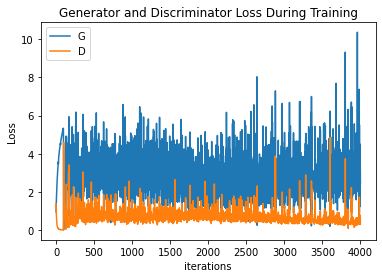

In [ ]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nc = 3

nz = 100

ngf = 128

ndf = 128



def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


netG = DCGAN_Generator().to(device)
netD = DCGAN_Discriminator().to(device)


netG.apply(weights_init)
netD.apply(weights_init)



criterion = nn.BCELoss()

fixed_noise = torch.randn(36, nz, 1, 1, device=device)


real_label = 1
fake_label = 0

learning_rate = 0.0002
beta1 = 0.5


optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

img_list = []
real_img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

  
def load_param(num_eps):
  model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
  netG.load_state_dict(model_saved['netG'])
  netD.load_state_dict(model_saved['netD'])

# GAN Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(gan_train_loader, 0):
        real = data[0].to(device)
        b_size = real.size(0)
        noise = torch.randn(b_size, nz, 1, 1, device=device)

        Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)
  
        netD.zero_grad()

        loss_D, fake = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion)



        loss_D.backward()
 
        optimizerD.step()

        netG.zero_grad()
   
        loss_G = loss_generator(netD, fake, Valid_label, criterion)
       
        loss_G.backward()
      
        optimizerG.step()

      
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                  % (epoch, num_epochs, i, len(gan_train_loader),
                     loss_D.item(), loss_G.item()))


        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())

        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake,nrow=6, padding=2, normalize=True))

        iters += 1

        

plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

checkpoint = {'netG': netG.state_dict(),
              'netD': netD.state_dict()}
torch.save(checkpoint, '/content/gan_{}.pt'.format(num_epochs))


## Qualitative Visualisations

### GAN Testing

In [ ]:
def show(img):
    img = img.cpu().detach()
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1,2,0)), interpolation='nearest')
    plt.show()

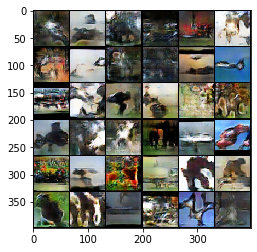

In [ ]:

fixed_noise = torch.randn(36, nz, 1, 1, device=device)
with torch.no_grad():
  fake = netG(fixed_noise).detach().cpu()
  val = vutils.make_grid(fake, nrow=6 ,padding=2, normalize=True)
  show(val)


### Visualisation at different epochs

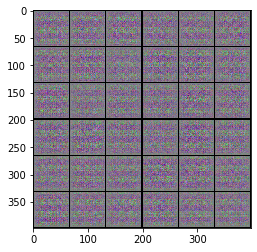

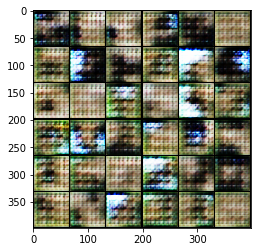

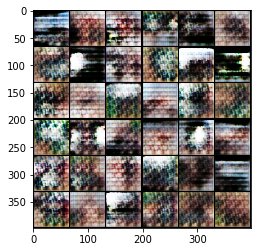

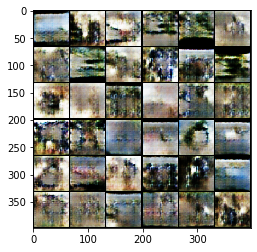

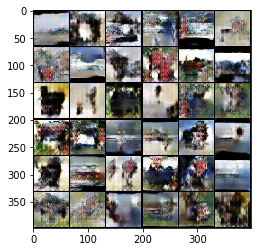

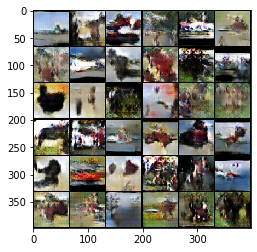

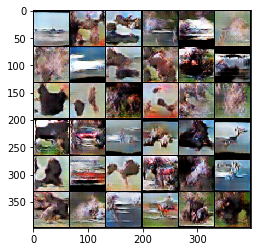

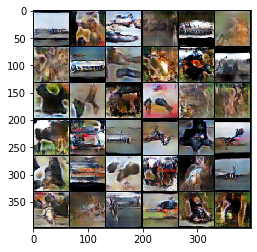

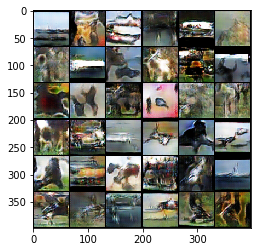

In [ ]:

for i in img_list:
  val = vutils.make_grid(i, nrow=6 ,padding=2, normalize=True)
  show(val)

## Quantitative Evaluation

In [ ]:
# Resize image to this size
image_size=64

# Setting up transforms to resize and normalize 
transform=transforms.Compose([ transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load STL-10 test set
test_batch_size = 1
gan_test_dataset = datasets.STL10(root='./stl10_data/', split='test', transform=transform, download=True)
gan_test_loader = torch.utils.data.DataLoader(dataset=gan_test_dataset, batch_size=test_batch_size, shuffle=False)

Files already downloaded and verified


### FID score for GAN

For this part, we should create three folder: 
- 1. STL_10_real_1 
- 2. STL_10_real_2 
- 3. STL_10_fake


In [ ]:
! mkdir STL_10_fake STL_10_real_1 STL_10_real_2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nc = 3

nz = 100

ngf = 128

ndf = 128

model_saved = torch.load('/content/gan_{}.pt'.format(num_epochs))
netG = DCGAN_Generator()
netG.load_state_dict(model_saved['netG'])
netG.to(device)


def denorm(x, norm_mean, norm_std):
    y = torch.zeros(x.shape)
    y[:,0,:,:] = x[:,0,:,:]*norm_std[0] + norm_mean[0]
    y[:,1,:,:] = x[:,1,:,:]*norm_std[1] + norm_mean[1]
    y[:,2,:,:] = x[:,2,:,:]*norm_std[2] + norm_mean[2]
    return y



evaluate_num = 1000


gen_set = []
for idx in range(evaluate_num):
    with torch.no_grad():
        fixed_noise = torch.randn(1, nz, 1, 1, device=device)
        fake = netG(fixed_noise).detach().cpu()
        fake = fake.cpu().detach()
        fake_denorm = denorm(fake, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

        gen_set.append(fake_denorm)

        save_image(fake.squeeze(), './STL_10_fake/fake' + str(idx) + '.png', normalize=True)

gen_dataset = TensorDataset(torch.cat(gen_set))


real_set_1 = []
real_set_2 = []

for idx, data in enumerate(gan_test_loader, 0):
    image = data[0]

    image_denorm = denorm(image, (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    if idx < evaluate_num:
        real_set_1.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_1/real' + str(idx) + '.png', normalize=True)
    elif evaluate_num <= idx < 2*evaluate_num:
        real_set_2.append(image_denorm)
        save_image(image.squeeze(), './STL_10_real_2/real' + str(idx) + '.png', normalize=True)
    if idx == 2*evaluate_num-1:
        break

# make the pytorch dataset
real_dataset_1 = TensorDataset(torch.cat(real_set_1))
real_dataset_2 = TensorDataset(torch.cat(real_set_2))


In [ ]:
! pip install pytorch-fid
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_1' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_real_2' --gpu 0
! python -m pytorch_fid '/content/STL_10_real_1' '/content/STL_10_fake' --gpu 0


### IS score for GAN

In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('IS score for real data set 1:')
print(inception_score(real_dataset_1, cuda=True, batch_size=64, resize=True, splits=1))
print('IS score for generated data set:')
print(inception_score(gen_dataset, cuda=True, batch_size=64, resize=True, splits=1))

IS score for real data set 1:


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



14.623443395832087
IS score for generated data set:
2.4545866833278525
